# **Mini-project n° 2– Conditional VAEs**
#### Groupe 12 : Laurié Romain, Richaume Julien, Cargnello Romain, Catalogna Lise

L'objectif de ce projet est de définir et d'entrainer un CVAE (Auto-Encoder Conditionnel Variationnel). 

Premièrement, nous installons toutes les librairies nécéssaires à ce projet.

In [32]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import Image
import pandas as pd
import itertools
from sklearn.decomposition import PCA

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset FashionMNIST

On télécharge les éléments du jeu de données FashionMNIST qui vont nous servir à mettre en place notre CVAE.

Fashion-MNIST est un jeu de données composé d'images d'articles de Zalando.

In [34]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

# Charger le jeu <de données Fashion-MNIST
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Création des échantillons test et train
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
print(f"Taille de l'échantillon d'entrainement : {len(train_dataset)}")
print(f"Taille de l'échantillon de test : {len(test_dataset)}")

Taille de l'échantillon d'entrainement : 60000
Taille de l'échantillon de test : 10000


Ce jeu de données est composé d'un ensemble d'apprentissage de 60 000 exemples et d'un ensemble de test de 10 000 exemples.

Chaque exemple est une image en niveaux de gris de 28x28, associée à une étiquette parmi 10 classes.
Nous associons dans le code ci-dessous la catégorie de vêtements à laquelle est associée chaque classe.

In [36]:
noms_classes = {
    0: "T-shirt/haut",
    1: "Pantalon",
    2: "Pull-over",
    3: "Robe",
    4: "Manteau",
    5: "Sandale",
    6: "Chemise",
    7: "Baskets",
    8: "Sac",
    9: "Bottines"
}


Nous affichons ci-dessous un exemple de 9 élèments tirés aléatoirement, provenant de l'échantillon d'entrainement et de leur label associé.

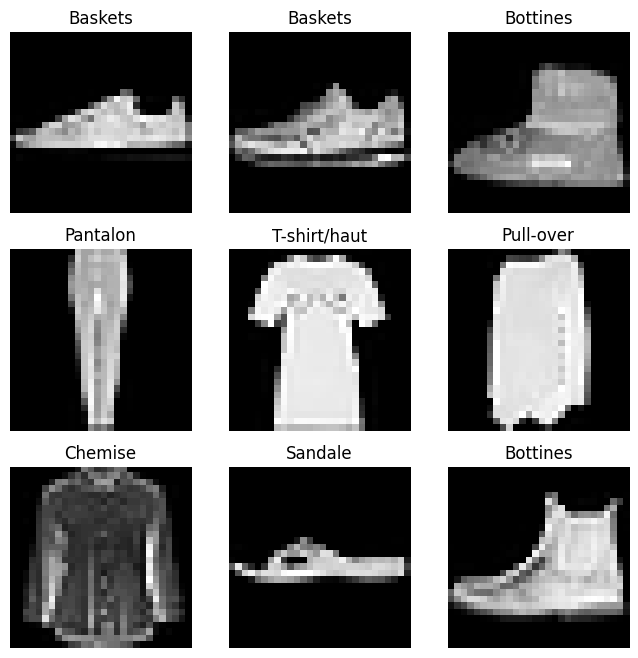

In [37]:
def plot_images(img_dataset):

    #Grille 3*3 pour permettre l'affichage de 9 images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
      
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  
        img, label = img_dataset[random_idx]  #récupération de l'image et de son label associé
        figure.add_subplot(rows, cols, i)  
        plt.title(noms_classes[label]) 
        plt.axis("off")  
        plt.imshow(img.squeeze(), cmap="gray") 
    
    plt.show()  

plot_images(train_dataset)

## **1. Mise en place d'un modèle CVAE :** 

### 1.1 Définition : 
On met en place ici un modèle VAE Conditionnel. C'est un modèle où l'encodage latent dépend des images d'entrée mais également des labels associés à chaque image. L'objectif de ce modèle est donc de générer des images en fonction d'une étiquette de données spécifique.

Un CVAE (Conditional Variational Autoencoder) est un modèle génératif qui apprend à produire des données conditionnées sur des informations spécifiques, comme des labels ou des attributs. Il encode les données d'entrée et les conditions dans un espace latent compact en produisant les paramètres d'une distribution gaussienne conditionnelle (moyenne et variance). En phase de génération, un échantillon est tiré de cette distribution, combiné avec les informations conditionnelles, et passé à un décodeur qui reconstruit les données ou en génère de nouvelles respectant les conditions

Ci-dessous, il est possible de visualiser un schéma de CVAE. 

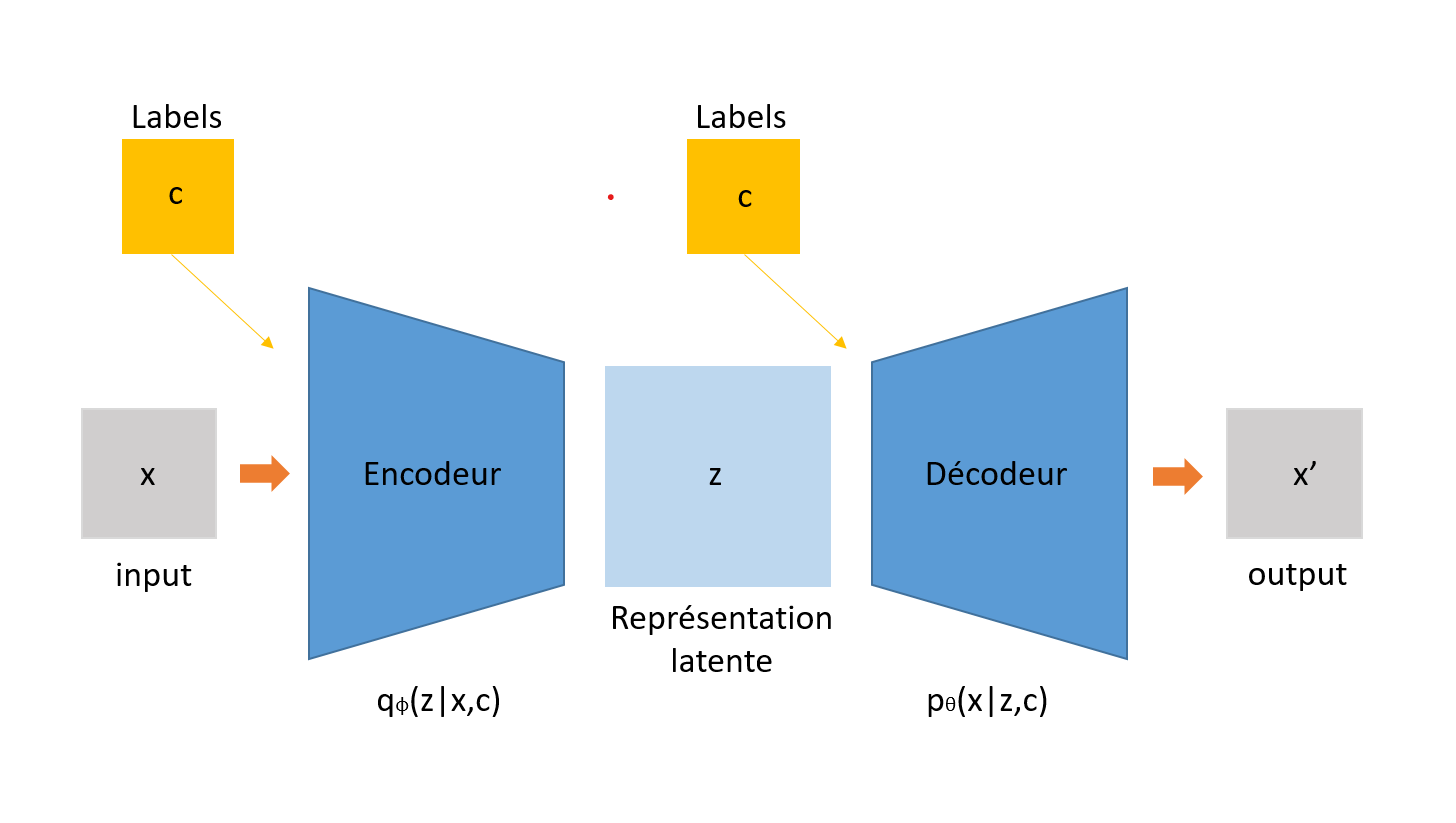

In [30]:
#img_path = 'C:/Users/lisec/OneDrive/Documents/cours/5A/HDDL/HDDL/Mini_Projet2/CVAE.png'
img_path = "CVAE.png"
Image(img_path, width=900)

La différence entre le VAE Conditionnel (CVAE) et le VAE simple est que l'on donne en entrée de l'encodeur et du décodeur du CVAE, un label pour lui donner l'information de ce qu'il a à produire. Ainsi, en ayant cette information, il peut se concentrer sur d'autres informations/aspects des données en entrée (la largeur de l'image, la densité de la coloration, etc).

Les images servent de modèles sur lesquels le décodeur peut se baser lors sa prédiction et les labels permettent ainsi de guider la prédiction vers un certain type d'image. 

Par exemple pour un VAE, on met en entrée de l'encodeur une image. Le décodeur doit donc reconnaitre cette image et tenter de la reproduire. Pour un CVAE, en plus de l'image donnée à l'encodeur, on fournit aussi le label de cette image (la catégorie à laquelle elle appartient) comme information conditionnelle au décodeur. Cela permet au décodeur 
de savoir d'avance qu'il doit reconstruire une image du label précisé, ce qui lui laisse plus de capacité pour se concentrer sur d'autres caractéristiques de l'image.

### 1.2 Choix de l'architecture : 

Pour le choix de l'architecture du modèle, nous avons choisi d'utiliser des couches convolutionnelles. En effet, celles-ci sont les plus adéquates pour l'analyse 
d'image, elles ont une approche locale et analysent les images zone par zone pour avoir des résultats précis. 
Les couches de convolution analyse graduellement l'image. La première couche analyse les petits motifs de l'image et les suivantes analysent les motifs de 
plus en plus gros.
 

Voici l'architecture du modèle CVAE mis en place: 

- **The Encoder:** 
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer


- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two paraller fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.


- **The Decoder.** 
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm laayer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

In [38]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # taille Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # taille Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # taille Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

    
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # taille Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # taille Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # taille Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten des couches de convolutions

        # Concaténation des labels à la sortie de l'encodeur
        x = torch.cat((x, labels), dim=1)
        mu = self.fc_mu(x) 
        logvar = self.fc_logvar(x)
        return mu, logvar

    # Gnération d'échantillon à partir de la distribution gaussienne par une méthode de reparamétrisation.
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=1)
        z = z.to(device)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        return self.decode(z, labels), mu, logvar

In [60]:
cvae1

ConvCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=2058, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=2058, out_features=2, bias=True)
  (fc_decode): Linear(in_features=12, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3)

La fonction ci-dessous va nous permettre de transformer les labels des données au format one-hot

In [39]:
#Récupération au format one-hot encoding des labels
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

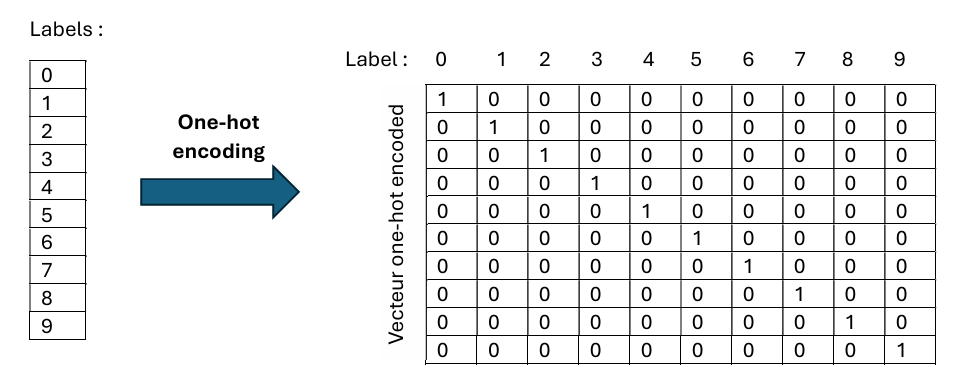

In [29]:
#img_path = 'C:/Users/lisec/OneDrive/Documents/cours/5A/HDDL/HDDL/Mini_Projet2/one-hot.png'
img_path = "one-hot.png"
Image(img_path, width = 900)

### 1.3 Fonction de perte

#### Choix de la fonction de perte : 

Voici la formule de la fonction de perte que nous avons décidé d'utiliser : 

\begin{align*}
\text{Loss} &= \text{BCE} + \beta \cdot \text{KLD} \\
\newline
\text{où } \quad \text{BCE} &= -\sum_{i} \left( x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right) \\
\text{KLD} &= -\frac{1}{2} \sum_{j} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
\end{align*}


Elle est composée de deux termes : la **cross entropy binaire** et la **divergence de Kullback-Leibler**.

- La première partie de la fonction de perte correspond à l'erreur de reconstruction, elle permet donc d'évaluer notre modèle et d'évaluer la fidélité des nouveaux données aux vraies données. Pour obtenir un modèle qui reconstruit bien, il faut minimiser la cross entropy entre la distribution de probabilité prédite et la réelle.

- La divergence de Kullback-Leibler est un facteur de régularisation. Il permet de mesurer la divergence entre deux distributions de probabilité et indique la proportion d'information perdue en utilisant une distribution pour représenter l'autre. Ce facteur permet de gérer la qualité de représentation des données dans l'espace latent qui a un impact direct sur la qualité de génération de nouveaux échantillons de données. Il implique aussi à l'espace latent d'être distribué normalement autour de 0.

- Le facteur β est un coefficient de pondération pour ajuster l'importance de la régularisation (terme KLD) par rapport à la reconstruction (terme cross-entropy). Plus β est grand, plus l'espace latent est proche d'une gaussienne centrée réduite. 



In [40]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') ## cross-entropy binaire
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) ## terme de divergence de KL
    return BCE + beta * KLD, BCE, KLD

### 1.4 Entrainement d'un modèle CVAE

Tout d'abord nous décidons d'entrainer un modèle avec des hyperparamètres choisis aléatoirement. Ce modèle servira de base, que l'on cherchera dans la suite à optimiser afin d'améliorer les prédictions. A la fin de nos analyses, nous comparerons ce modèle avec le modèle optimisé obtenu.

In [45]:
# hyperparamètres
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 2  

# Initialisation du modèle
cvae1 = ConvCVAE(latent_dim=latent_dim, num_classes=10)
cvae1.to(device)
optimizer = optim.Adam(cvae1.parameters(), lr=learning_rate)
# Boucle d'entrainement
for epoch in range(1, epochs + 1):
    cvae1.train()  # Mode entrainement
    running_loss = 0.0 

    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)  

        # Conversion des labels au format one-hot encoding
        one_hot_labels = one_hot(labels, class_size=10).to(device)  

        
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = cvae1(data, one_hot_labels)

        # Calcul de la loss
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]

        # Backpropagation
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    # Calcul de la loss pour l'epoch en cours
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


Epoch 1, Training loss: 279.0810
Epoch 2, Training loss: 261.9600
Epoch 3, Training loss: 260.4237
Epoch 4, Training loss: 259.4484
Epoch 5, Training loss: 258.8661
Epoch 6, Training loss: 258.2365
Epoch 7, Training loss: 257.8203
Epoch 8, Training loss: 257.6208
Epoch 9, Training loss: 257.2215
Epoch 10, Training loss: 256.9695
Epoch 11, Training loss: 256.7047
Epoch 12, Training loss: 256.5643
Epoch 13, Training loss: 256.3074
Epoch 14, Training loss: 256.1689
Epoch 15, Training loss: 255.9794
Epoch 16, Training loss: 255.8137
Epoch 17, Training loss: 255.7721
Epoch 18, Training loss: 255.5829
Epoch 19, Training loss: 255.4272
Epoch 20, Training loss: 255.4151
Epoch 21, Training loss: 255.1923
Epoch 22, Training loss: 255.0566
Epoch 23, Training loss: 255.0326
Epoch 24, Training loss: 254.9792
Epoch 25, Training loss: 254.8420
Epoch 26, Training loss: 254.7741
Epoch 27, Training loss: 254.6557
Epoch 28, Training loss: 254.5814
Epoch 29, Training loss: 254.5270
Epoch 30, Training loss

Après 30 epochs, la fonction de perte atteint la valeur de 255,9237 sur l'échantillon de données d'entrainement. La valeur de la fonction de perte n'est pas ici optimisée, elle ne converge pas car on n'a toujours pas atteint de pallier.

### 1.5 Evaluation du modèle sur l'échantillon de test

Afin de quantifier la reconstruction des données grace au modèle CVAE construit précédemment et d'évaluer par la suite les hyper-paramètres utilisés, nous affichons la MSE et la fonction de test de l'échantillon de test.

In [46]:
cvae1.eval() #mode évaluation

with torch.no_grad():
    test_loss, test_mse = 0.0, 0.0
    for data, labels in test_loader:
        data = data.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device) #conversion au format one-hot
        
        recon_batch, mu, logvar = cvae1(data, one_hot_labels)
        loss, _, _ = loss_function(recon_batch, data, mu, logvar, beta=beta)
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        test_loss += loss.item()
        test_mse += mse

    test_loss /= len(test_loader.dataset)
    test_mse /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}")


Test Loss: 256.7686, Test MSE: 0.0002


Ces valeurs nous permettrons par la suite de comparer les différents modèles.

### 1.6 Visualisation des résultats obtenus

**Reconstruction des données d'entrée**

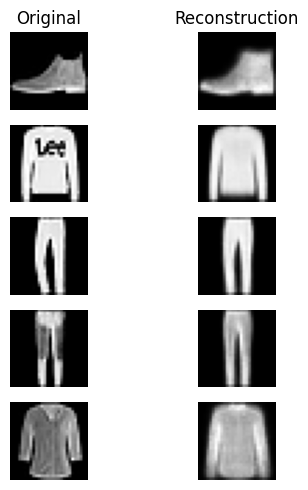

In [47]:
def image_comparison(original_images, reconstructions, n_images=5):

    fig, ax = plt.subplots(n_images, 2, figsize=(5, 5))

    for i in range(n_images):
        # Plot des images originales
        ax[i, 0].imshow(original_images[i], cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_xlabel("0")
        ax[0, 0].set_title('Original')

        # Plot des images reconstruites
        ax[i, 1].imshow(reconstructions[i], cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_xlabel("1")
        ax[0, 1].set_title('Reconstruction')

    
    plt.tight_layout()
    plt.show()

# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae1(random_images.to(device), one_hot_labels)  


random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

image_comparison(random_images, recons)


Le modèle CVAE construit précédemment nous permet d'obtenir les résultats précédents. Il tente ici de reproduire à l'identique les données d'entrée. La qualité de reconstruction du modèle est ici évaluée. 

On constate que  les vêtements produits sont reconnaissables. Cependant, les images sont un peu flous. 

**Génération de nouveaux échantillons de données**

Ci-dessous, le modèle CVAE construit précedemment génère de nouvelles données, soit 5 nouveaux échantillons par classe.

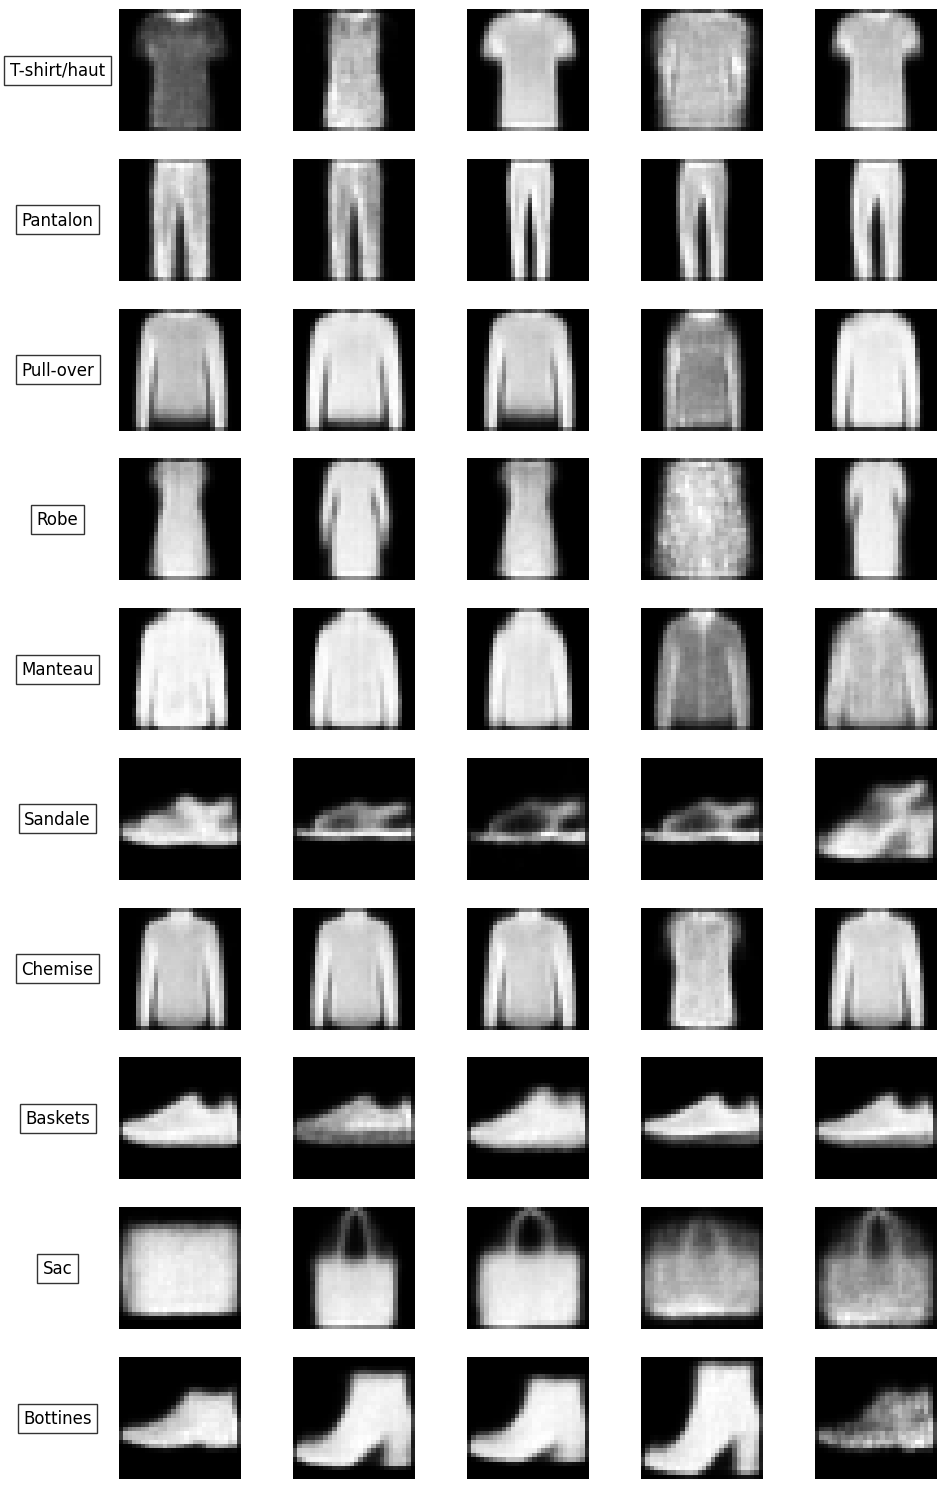

In [48]:
cvae1.eval() #modèle en mode évaluation

num_classes = 10 
num_samples_per_class = 5 #nombre d'exemples par classe affichés

#Fonction pour générer et afficher des échantillons pour chaque classe
def generate_samples_per_class(model, num_classes, num_samples):
    samples = []
    for class_label in range(num_classes):
        class_samples = []
        for _ in range(num_samples):
         
            y = torch.tensor([class_label]).to(torch.long)
            y = torch.nn.functional.one_hot(y, num_classes).float()

            z = torch.randn(1, model.latent_dim) 
            
            #Passer z et y dans le décodeur
            with torch.no_grad():
                generated_image = model.decode(z, y)
                
            class_samples.append(generated_image.squeeze().cpu())
            
        samples.append(class_samples)
        
    return samples


#Générer les échantillons
samples = generate_samples_per_class(cvae1, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, noms_classes[class_label], 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

La génération de données donne des résultats assez flous, mais les élèments sont reconnaissables, nous allons dans la suite tenter d'optimiser ces résultats.

## **2. Optimisation du modèle CVAE**
Maintenant que nous avons des premiers résultats, nous nous intéressons aux choix des hyperparamètres pour tenter d'améliorer notre modèle.

### 2.1 Définition des hyperparamètres : 

Dans les hyper-paramètres du modèle, on décide d'optimiser uniquement le poids de régularisation (facteur β) et la dimension latente. Les hyper-paramètres de la taille du batch et du learning rate n'ont pas une grande influence donc par manque de temps, on les prend arbitrairement à eps = 10-3 et taille du batch=128. 

- L'optimisation du facteur β permet de trouver un compromis optimal de résultat, il donne plus ou moins de poids au terme de divergence de KL qui permet d'assurer une bonne représentation des données dans l'espace latent.

- La dimension latente détermine la capacité du modèle à capturer les informations pertinentes des données dans un espace de plus faible dimension.

- La taille du batch influence en grande partie sur la stabilité de l'optimisation et la rapidité des calculs mais son impact n'a pas une grande influence sur les performences du modèle final. 

- Le taux d'apprentissage détermine la vitesse à laquelle le modèle converge vers un minimum local. Il est donc important de bien le choisir, un ordre de grandeur entre 10-3 et 10-4 est généralement efficace. Optimiser ce paramètres n'est donc pas nécessaire dans un premier temps.

- Le nombre d'epochs détermine combien de fois le modèle parcourt l'ensemble des données d'entraînement. Ce paramètre permet d'assurer une bonne convergence du modèle 
sans provoquer de surapprentissage. 

### 2.2 Optimisation des paramètres

Ci-dessous nous tentons d'optimiser le modèle CVAE par deux méthodes : avec une grille de paramètres et avec la librairie Optuna

Tout d'abord on met en place la première méthode. Dans notre cas on choisit d'optimiser la variable beta et laa dimension de l'espace latent. Plusieurs choix de valeurs sont données afin que le code établisse des combinaisons de paramètres différents. Plusieurs modèle CVAE sont entrainés avec des combinaisons d'hyper-paramètres différents dans le but de trouver la combinaison la plus optimale.

afficher la loss courbe pour chaque combi

#### Optimisation avec des combinaisons d'hyper-paramètres

In [15]:
def train_with_different_params(param_grid, batch_size=128):
    # Générer toutes les combinaisons possibles et uniques d'hyperparamètres
    param_combinations = list(itertools.product(
        param_grid['latent_dim'],
        param_grid['learning_rate'],
        param_grid['epochs'],
        param_grid['beta']
    ))
    print(param_combinations)

    # Liste pour stocker les résultats
    results = []

    # Itérer sur chaque combinaison unique
    for latent_dim, learning_rate, epochs, beta in param_combinations:
        params = {
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "beta": beta
        }
        print(f"\nTraining with params: {params}")
        
        # Initialisation du modèle et de l'optimiseur
        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        # Liste pour stocker les pertes
        epoch_losses = []
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Calcul Loss et MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            #Calcul loss et MSE moyenne sur le dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            epoch_losses.append(epoch_loss)  
            
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}")
        
        # Tracer la courbe de perte pour cette combinaison d'hyperparamètres
        plt.plot(range(1, epochs + 1), epoch_losses, label=f"ld={latent_dim}, lr={learning_rate}, beta={beta}")
        
        # enregistrement des résultats dans le tableau results
        results.append({
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "beta": beta,
            "final_loss": epoch_loss,
            "final_mse": epoch_mse
        })

    plt.title("Courbes de perte pour chaque combinaison d'hyperparamètres")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()


    results_df = pd.DataFrame(results)
    print("\nSummary of hyperparameter tuning:")
    #print(results_df)
    
    # Enregistrement au format csv des résultats
    results_df.to_csv("hyperparameter_tuning_results.csv", index=False)
    
    return results_df


[(10, 0.001, 15, 0.1), (10, 0.001, 15, 1), (10, 0.001, 15, 5), (10, 0.001, 15, 10), (20, 0.001, 15, 0.1), (20, 0.001, 15, 1), (20, 0.001, 15, 5), (20, 0.001, 15, 10), (40, 0.001, 15, 0.1), (40, 0.001, 15, 1), (40, 0.001, 15, 5), (40, 0.001, 15, 10)]

Training with params: {'latent_dim': 10, 'learning_rate': 0.001, 'epochs': 15, 'beta': 0.1}
Epoch 1/15, Loss: 244.5588, MSE: 0.0002
Epoch 2/15, Loss: 226.6090, MSE: 0.0001
Epoch 3/15, Loss: 224.2591, MSE: 0.0001
Epoch 4/15, Loss: 222.9794, MSE: 0.0001
Epoch 5/15, Loss: 221.9807, MSE: 0.0001
Epoch 6/15, Loss: 221.3479, MSE: 0.0001
Epoch 7/15, Loss: 220.8300, MSE: 0.0001
Epoch 8/15, Loss: 220.4092, MSE: 0.0001
Epoch 9/15, Loss: 220.0525, MSE: 0.0001
Epoch 10/15, Loss: 219.7603, MSE: 0.0001
Epoch 11/15, Loss: 219.4335, MSE: 0.0001
Epoch 12/15, Loss: 219.2387, MSE: 0.0001
Epoch 13/15, Loss: 219.0863, MSE: 0.0001
Epoch 14/15, Loss: 218.8470, MSE: 0.0001
Epoch 15/15, Loss: 218.6463, MSE: 0.0001

Training with params: {'latent_dim': 10, 'learning

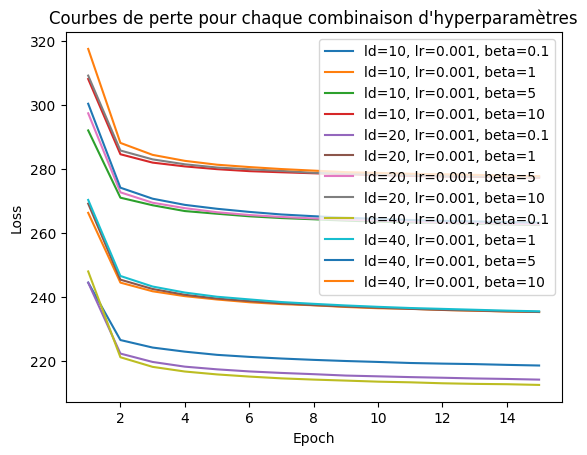


Summary of hyperparameter tuning:


latent_dim  learning_rate  epochs  beta  final_loss  final_mse
0           10          0.001      15   0.1  218.646280   0.000090
1           10          0.001      15   1.0  235.361343   0.000113
2           10          0.001      15   5.0  262.553411   0.000184
3           10          0.001      15  10.0  277.325577   0.000230
4           20          0.001      15   0.1  214.235788   0.000069
5           20          0.001      15   1.0  235.377031   0.000109
6           20          0.001      15   5.0  262.764686   0.000185
7           20          0.001      15  10.0  277.539992   0.000232
8           40          0.001      15   0.1  212.580092   0.000058
9           40          0.001      15   1.0  235.586442   0.000110
10          40          0.001      15   5.0  263.317111   0.000188
11          40          0.001      15  10.0  277.848111   0.000234

In [16]:
param_grid = {
    'latent_dim': [10, 20, 40],  rès bons
    'epochs': [15],
    'beta': [0.1, 1, 5, 10],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)

Après l'optimisation des hyper-paramètres précedentes, on constate que la perte et la MSE sont minimisées avec β=0.1. On remarque également que la dimension de l'espace latent à un impact sur la valeur de la loss. En effet, plus la dimension de l'espace est importante, plus la loss est faible.

Ainsi, après 15 epochs, si en se basant sur la loss et la MSE nous devons sélectionner le meilleur modèle, nous choisirions (latent_dim=40, learning_rate=1e-3, β=0.1).

#### Optimisation avec la library Optuna

Nous tentons dans cette partie d'utiliser une autre méthode afin d'optimiser le modèle CVAE, nous utilisons pour cela la librairie Optuna. Elle permet de trouver les meilleurs paramètres pour un modèle en minimisant ou maximisant une fonction objectif définie par l'utilisateur. Dans notre cas nous avons choisi de minimiser la fonction objectif définie ci-dessous.

In [15]:
import optuna

def objective(trial): #définition de la fonction à optimiser
 
    latent_dim = trial.suggest_categorical('latent_dim', [10, 20, 40]) #possibilité de choix pour l'hyperparamètre de la dim latente
    beta = trial.suggest_categorical('beta', [0.1, 1, 5, 10]) #possibilité de choix pour l'hyperparamètre beta

    
    cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
    
    running_loss = 0.0
    running_mse = 0.0
    
    for epoch in range(10): 
        cvae.train()
        for data, labels in train_loader:
            data = data.to(device)
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, one_hot_labels)
            
            loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
            mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse

  
    avg_loss = running_loss / len(train_loader.dataset)
    avg_mse = running_mse / len(train_loader.dataset)
    return avg_mse


study = optuna.create_study(direction='minimize') #souhait de minimisation pour l'optimisation de la fonction
study.optimize(objective, n_trials=12) #optimisation de la fonction objective avec 12 essais

# Meilleurs paramètres 
print("\nBest trial:")
print(study.best_trial.params)


[I 2024-12-19 11:55:50,986] A new study created in memory with name: no-name-82fcdb1d-b4a6-4b73-a30b-30c0f6f9a525
[I 2024-12-19 11:57:14,719] Trial 0 finished with value: 0.0013161531661481907 and parameters: {'latent_dim': 20, 'beta': 1}. Best is trial 0 with value: 0.0013161531661481907.
[I 2024-12-19 11:58:39,139] Trial 1 finished with value: 0.0013372459417364249 and parameters: {'latent_dim': 40, 'beta': 1}. Best is trial 0 with value: 0.0013161531661481907.
[I 2024-12-19 12:00:05,529] Trial 2 finished with value: 0.001311652660664792 and parameters: {'latent_dim': 40, 'beta': 1}. Best is trial 2 with value: 0.001311652660664792.
[I 2024-12-19 12:01:32,412] Trial 3 finished with value: 0.002599963125307113 and parameters: {'latent_dim': 40, 'beta': 10}. Best is trial 2 with value: 0.001311652660664792.
[I 2024-12-19 12:02:57,342] Trial 4 finished with value: 0.0025863565423836312 and parameters: {'latent_dim': 40, 'beta': 10}. Best is trial 2 with value: 0.001311652660664792.
[I 2


Best trial:
{'latent_dim': 10, 'beta': 0.1}


Le résultat obtenu ici valide l'optimisation précédente puisque les résultats avec les deux méthodes sont les mêmes.

### 2.3 Entrainement du modèle optimisé

Afin de vérifier l'optimisation du modèle CVAE effectuée, nous allons entrainer un modèle avec les hyper-paramètres sélectionnés pour pouvoir afficher les résultats.

Epoch 1, Training loss: 248.4126,  Training mse: 0.0002
Epoch 2, Training loss: 221.1648,  Training mse: 0.0001
Epoch 3, Training loss: 218.2364,  Training mse: 0.0001
Epoch 4, Training loss: 216.7556,  Training mse: 0.0001
Epoch 5, Training loss: 215.8149,  Training mse: 0.0001
Epoch 6, Training loss: 215.1879,  Training mse: 0.0001
Epoch 7, Training loss: 214.6535,  Training mse: 0.0001
Epoch 8, Training loss: 214.2104,  Training mse: 0.0001
Epoch 9, Training loss: 213.8369,  Training mse: 0.0001
Epoch 10, Training loss: 213.6025,  Training mse: 0.0001
Epoch 11, Training loss: 213.3160,  Training mse: 0.0001
Epoch 12, Training loss: 213.0875,  Training mse: 0.0001
Epoch 13, Training loss: 212.8988,  Training mse: 0.0001
Epoch 14, Training loss: 212.7153,  Training mse: 0.0001
Epoch 15, Training loss: 212.5718,  Training mse: 0.0001
Epoch 16, Training loss: 212.4288,  Training mse: 0.0001
Epoch 17, Training loss: 212.3084,  Training mse: 0.0001
Epoch 18, Training loss: 212.1042,  Trai

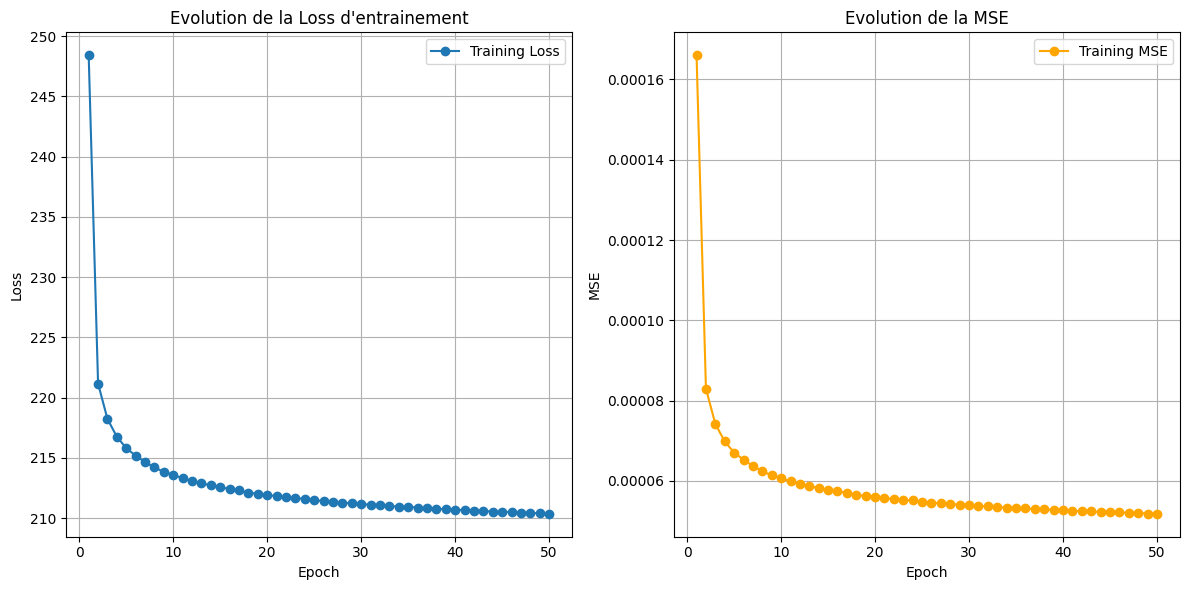

In [38]:
#Hyper-paramètres choisis à partir des optimisations précédentes
batch_size = 128
latent_dim = 40
learning_rate = 1e-3
epochs = 50
beta = 0.1

# initialisation du modèle
cvae2 = ConvCVAE(latent_dim=latent_dim, num_classes=10) 
cvae2.to(device)
optimizer = optim.Adam(cvae2.parameters(), lr=learning_rate)

# Listes pour stocker la loss et la MSE par epoch
loss_history2 = []
mse_history2 = []

for epoch in range(1, epochs + 1):
    cvae2.train()  # Entraînement du modèle
    
    # Initialisation des métriques
    running_loss = 0.0  
    running_mse = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # Conversion des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae2(data, one_hot_labels)

        # Calcul des métriques
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse += mse

    # Calcul de la loss et de la MSE par epoch
    epoch_loss2 = running_loss / len(train_loader.dataset)
    epoch_mse2 = running_mse / len(train_loader.dataset)
    loss_history2.append(epoch_loss2)
    mse_history2.append(epoch_mse2)
    
    print(f'Epoch {epoch}, Training loss: {epoch_loss2:.4f},  Training mse: {epoch_mse2:.4f}')

# Traçage des courbes
plt.figure(figsize=(12, 6))

# Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_history2, marker='o', label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution de la Loss d'entrainement")
plt.grid()
plt.legend()

# Courbe de MSE
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), mse_history2, marker='o', label="Training MSE", color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Evolution de la MSE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


On affiche ci-dessous l'évolution de la Loss et de la MSE au cours de l'entrainement du modèle optimisé. Après 50 epochs la convergence de la loss et de la mse est quasi atteinte. 

### 2.4 Evaluation du modèle optimisé

In [39]:
cvae2.eval() #mode évaluation

with torch.no_grad():
    test_loss2, test_mse2 = 0.0, 0.0
    for data, labels in test_loader:
        data = data.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)
        
        recon_batch, mu, logvar = cvae2(data, one_hot_labels)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta=beta)
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        test_loss2 += loss.item()
        test_mse2 += mse

    test_loss2 /= len(test_loader.dataset)
    test_mse2 /= len(test_loader.dataset)

print(f"Test Loss: {test_loss2:.4f}, Test MSE: {test_mse2:.4f}")


Test Loss: 212.4417, Test MSE: 0.0001


Ci-dessus se trouve la valeur de la fonction de perte et de la MSE finales sur l'échantillon de test.

**Comparaison des résultats du modèle initial et du modèle optimisé** : 

In [40]:
print("Test loss modèle de base : " + str(test_loss))
print("Test mse modèle de base : " + str(test_mse))
print("---------------------------------------------")
print("Test loss modèle optimisé : " + str(test_loss2))
print("Test mse modèle optimisé : " + str(test_mse2))

Test loss modèle de base : 256.72140390625
Test mse modèle de base : 0.00020067539177834987
---------------------------------------------
Test loss modèle optimisé : 212.44168510742188
Test mse modèle optimisé : 5.48255083616823e-05


En comparaison avec le modèle initial, on peut voir que la loss et la mse sont bien plus faibles sur le modèle optimisé. La fonction de perte et la MSE ont bien été minimisées au cours de l'optimisation des hyper-paramètres.

### 2.5 Visualisation des résultats obtenus

Afin d'avoir un résultat plus visuel des résultats du modèle optimisés, nous affichons ici la reconstruction des données d'entrée ainsi que la génération de nouvelles données.

**Reconstruction des données d'entrée**

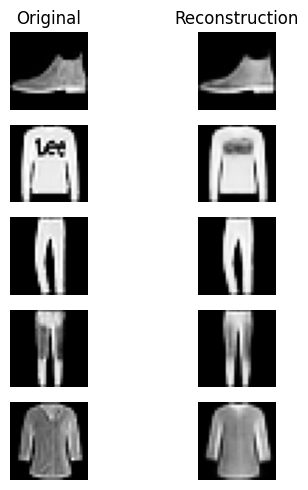

In [41]:
# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae2(random_images.to(device), one_hot_labels)  

random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

image_comparison(random_images, recons)

La reconstruction des données marche plutot bien, les images reconstruites sont fidèles aux images originales, bien que toujours un peu floues.

**Génération d'échantillons de données aléatoires**

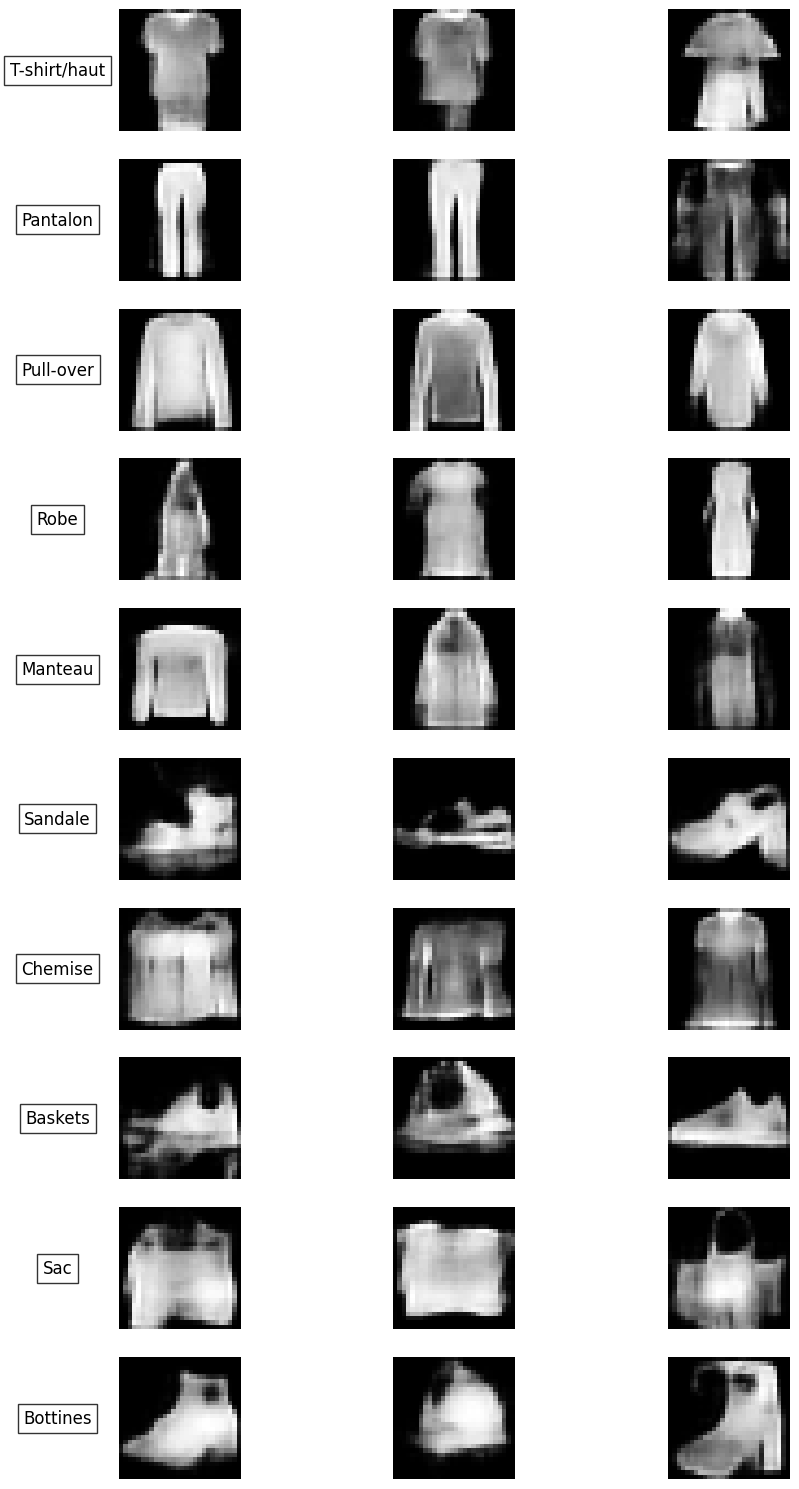

In [61]:
num_samples_per_class = 3
num_classes = 10

samples = generate_samples_per_class(cvae2, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, noms_classes[class_label], 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

La génération de données avec le modèle optimisés est très mauvaise, les vêtements ne sont pas reconnaissables et les images extrêments floues. 

Nous allons dans la suite expliquer ce phénomène.

## **3. Génération vs Reconstruction**

#### 3.1 Influence du β sur la représentation des données dans l'espace latent

On décide de visualiser la représentation de l'espace latent avec différentes valeurs de beta, donc différents poids de la KLD dans notre fonction de perte.
Cela nous permettrait de juger quel beta nous donne la meilleur génération des données dans cet espace. L'idéal serait d'obtenir des données réparties par classes distinctes.

On projette ici les données selon les 2 composantes principales, en utilisant la méthode de PCA (Principal Component Analysis)


Training CVAE with beta = 0.01

Training CVAE with beta = 0.1

Training CVAE with beta = 1

Training CVAE with beta = 5

Training CVAE with beta = 10


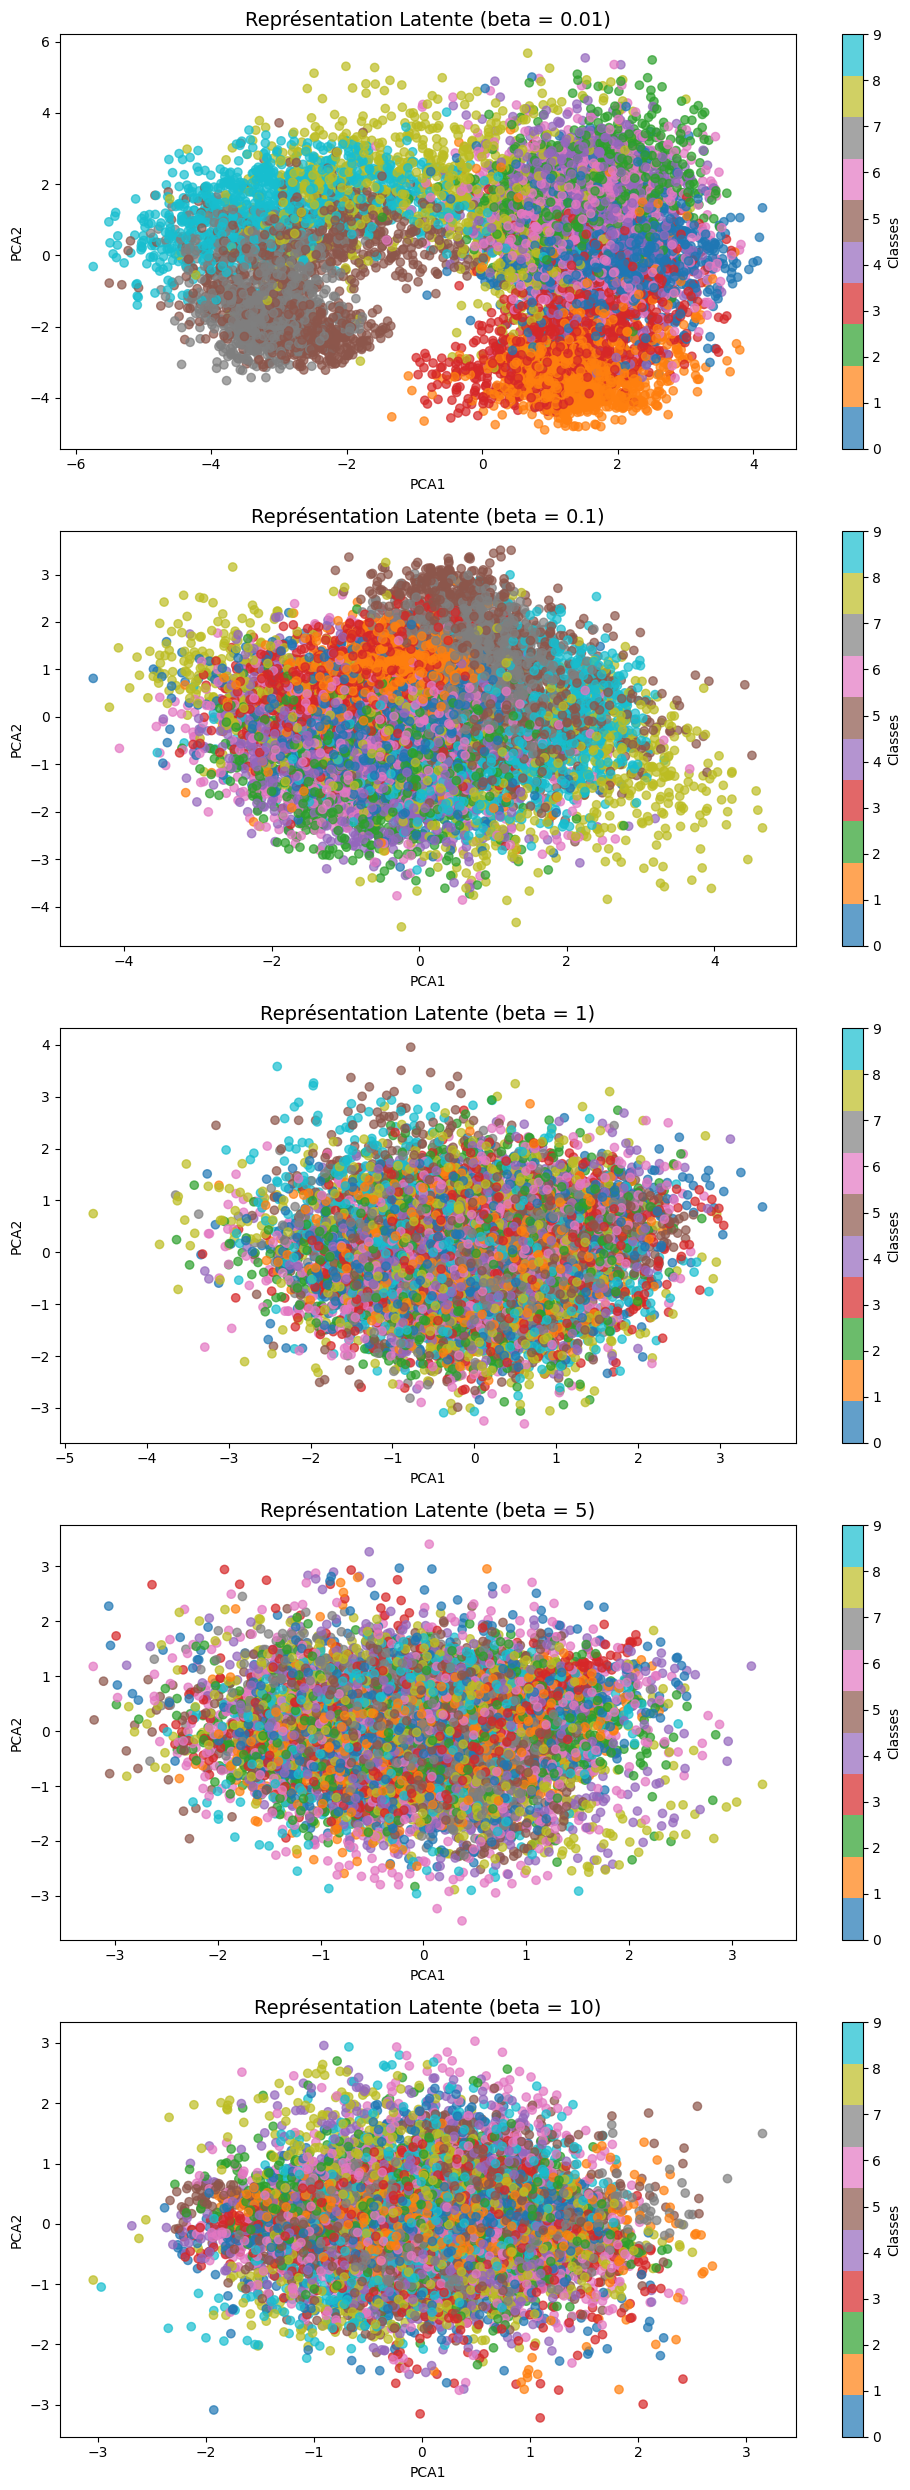

In [13]:
latent_dims = 20
batch_size = 128
num_epochs = 20
learning_rate = 1e-3
beta_values = [0.01, 0.1, 1, 5, 10] 

def train_and_plot(beta):
    model = ConvCVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            one_hot_labels = one_hot(labels, class_size=10).to(device)

            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, one_hot_labels)

      
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(average_loss)

    return model

# Création de sous-graphes pour chaque beta
fig, axs = plt.subplots(len(beta_values), 1, figsize=(10, 5 * len(beta_values)))

for idx, beta in enumerate(beta_values):
    print(f'\nTraining CVAE with beta = {beta}')
    model = train_and_plot(beta)
    model.eval()

    # Représentation latente
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)

        # Encodage des données
        mu, logvar = model.encode(data, one_hot_labels)
        z = mu.cpu().numpy()
        labels = labels.cpu().numpy()

        # Application de PCA pour réduire à 2 dimensions
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z) 

        
        scatter = axs[idx].scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
        axs[idx].set_title(f'Représentation Latente (beta = {beta})', fontsize=14)
        axs[idx].set_xlabel('PCA1')
        axs[idx].set_ylabel('PCA2')


        # barre de couleur
        fig.colorbar(scatter, ax=axs[idx], ticks=range(10), label='Classes')


plt.tight_layout()
plt.show()

**Observations :**
On remarque ici que plus beta est petit plus les différentes classes se distinguent dans la représentation de l'espace latent. Avec un beta grand, les données sont tous regroupés et centrés.

En effet, plusieurs paramètres influent sur cette représentation latente.

Tout d'abord, **la valeur de β**, suivant la valeur de ce paramètre, le facteur de divergence de KL a plus ou moins d'impact. 
- Si β est faible, le modèle accorde plus de poids à la reconstruction des données qu'à la régularisation de l'espace latent. Le facteur de régularisation est sous-pondérée, ce qui peut entraîner un espace latent moins "gaussien" où les classes sont regroupées entres-elles, comme constaté précedemment. Les données en sortie seront plus ressemblants aux données d'entrée mais la qualité de généralisation sera moindre. 
- Si au contraire, β est grand le facteur de régularsation de KL a un impact important, cela impose une régularisation plus forte sur l'espace latent. Les données se rapprocheront d'une représentation gaussienne dans l'espace latent. Les données en sortie ne seront plus fidèles aux données d'entrée, mais la qualité de généralisation de données du modèle sera bonne.

Ensuite **la dimension de l'espace latent** : l'espace latent doit résumer les données de manière compacte et en tirer les propriétés essentielles. 
- Une faible dimension de l'espace latent est adapté pour représenter des données simples. En effet, un espace latent de faible dimension force le modèle à résumer les données en leurs caractéristiques les plus essentielles
- Au contraire, une dimension de l'espace latente importante permet mieux de représenter des données plus complexes. Il doit capturer des nuances plus importantes et plus précises si le modèle est complexe, donc doit etre de plus grande dimension.

Dans une situation idéale, on voudrait que notre modèle reproduise bien les données mais qu'il génére également correctement de nouvelles données. 
- La qualité de recontruction est gérée par le premier facteur de la fonction de perte : la cross-entropy binaire
- La qualité de génération de données est controlée par le deuxième facteur de la fonction de perte : le terme de divergence de KL

Ainsi, afin d'avoir le meilleur modèle, il faudrait donc trouver un compromis entre les deux aspects précedents ou faire un choix suivant l'objectif final du projet.

#### 3.2 Modèle CVAE avec β faible

Afin de vérifier les propos précédents, nous allons montrer les résultats avec un modèle dont l'hyper-paramètre beta est faible, même nul.

In [59]:
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
epochs = 15
beta = 0

# Modèle et optimizer
cvae_beta_petit = ConvCVAE(latent_dim=latent_dim, num_classes=10) 
cvae_beta_petit.to(device)
optimizer = optim.Adam(cvae_beta_petit.parameters(), lr=learning_rate)

# Listes pour stocker la loss et la MSE par epoch
loss_history_petit = []
mse_history_petit = []

for epoch in range(1, epochs + 1):
    cvae_beta_petit.train()  # Entraînement du modèle
    
    # Initialisation des métriques
    running_loss = 0.0  
    running_mse = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # Conversion des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae_beta_petit(data, one_hot_labels)

        # Calcul des métriques
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse += mse

    # Calcul de la loss et de la MSE par epoch
    epoch_loss_petit = running_loss / len(train_loader.dataset)
    epoch_mse_petit = running_mse / len(train_loader.dataset)
    loss_history_petit.append(epoch_loss_petit)
    mse_history_petit.append(epoch_mse_petit)
    
    print(f'Epoch {epoch}, Training loss: {epoch_loss_petit:.4f},  Training mse: {epoch_mse_petit:.4f}')


Epoch 1, Training loss: 244.9200,  Training mse: 0.0002
Epoch 2, Training loss: 217.2767,  Training mse: 0.0001
Epoch 3, Training loss: 214.1218,  Training mse: 0.0001
Epoch 4, Training loss: 212.5988,  Training mse: 0.0001
Epoch 5, Training loss: 211.5845,  Training mse: 0.0001
Epoch 6, Training loss: 210.9109,  Training mse: 0.0001
Epoch 7, Training loss: 210.4151,  Training mse: 0.0001
Epoch 8, Training loss: 209.9928,  Training mse: 0.0001
Epoch 9, Training loss: 209.6449,  Training mse: 0.0001
Epoch 10, Training loss: 209.3782,  Training mse: 0.0001
Epoch 11, Training loss: 209.1067,  Training mse: 0.0001
Epoch 12, Training loss: 208.9404,  Training mse: 0.0001
Epoch 13, Training loss: 208.6922,  Training mse: 0.0001
Epoch 14, Training loss: 208.5677,  Training mse: 0.0001
Epoch 15, Training loss: 208.3797,  Training mse: 0.0001


Evaluation du modèle

In [61]:
cvae_beta_petit.eval()

ConvCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=2058, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=2058, out_features=20, bias=True)
  (fc_decode): Linear(in_features=30, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (

Reconstruction d'images

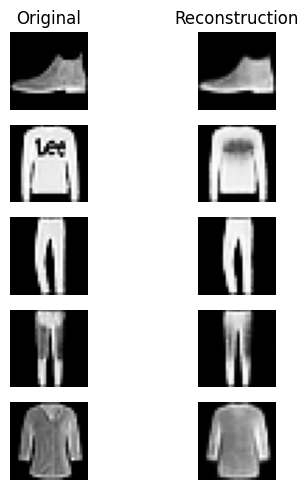

In [62]:
# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae_beta_petit(random_images.to(device), one_hot_labels)  

random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

image_comparison(random_images, recons)

Génération d'échantillons aléatoires

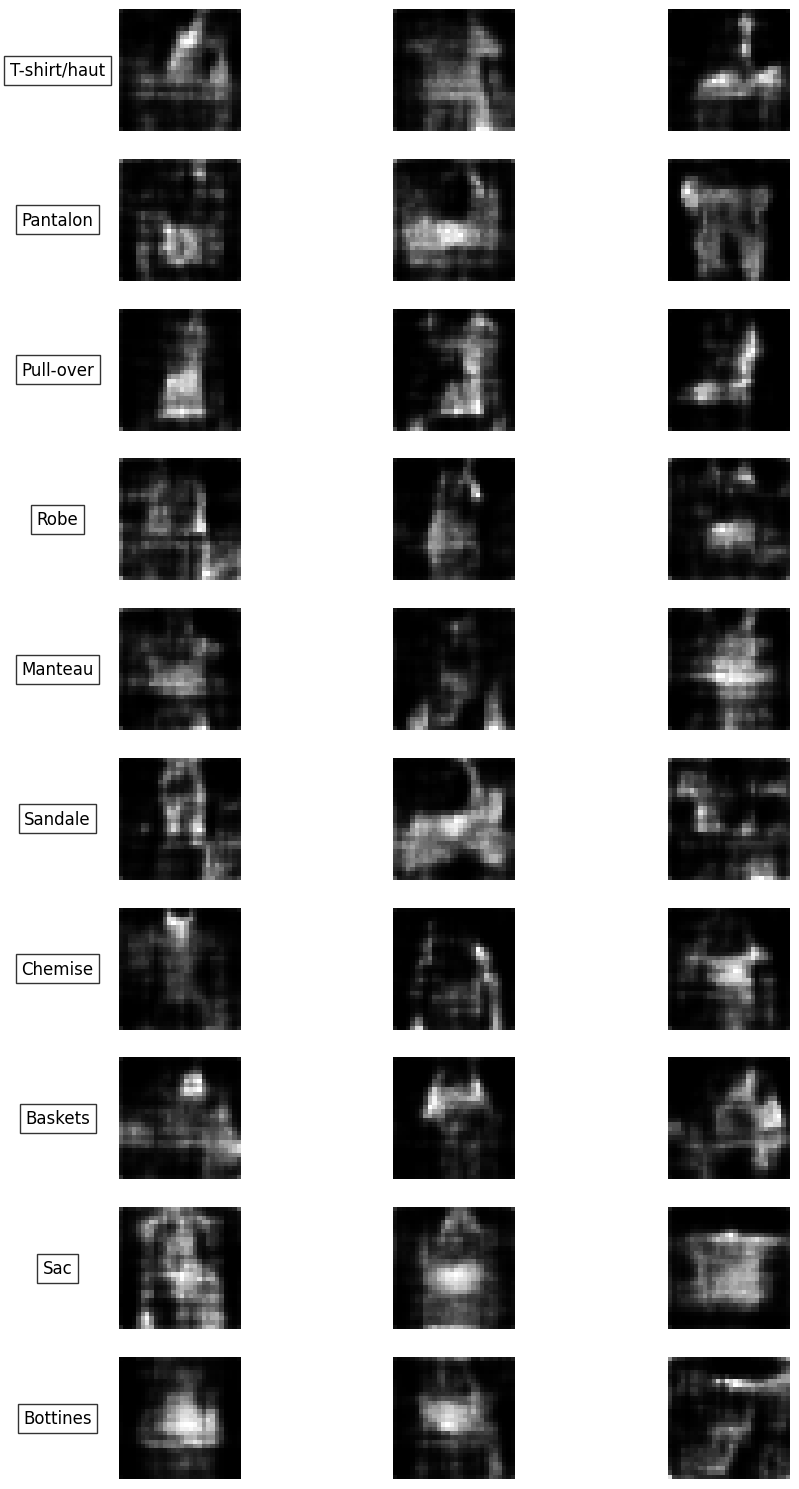

In [63]:
num_samples_per_class = 3
num_classes = 10

samples = generate_samples_per_class(cvae_beta_petit, num_classes, num_samples_per_class)

fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, noms_classes[class_label], 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

Pour un beta faible, la reconstruction des données est effectivement bonne. Cependant, comme prévu, la génération des données n'est vraiment pas bonne.

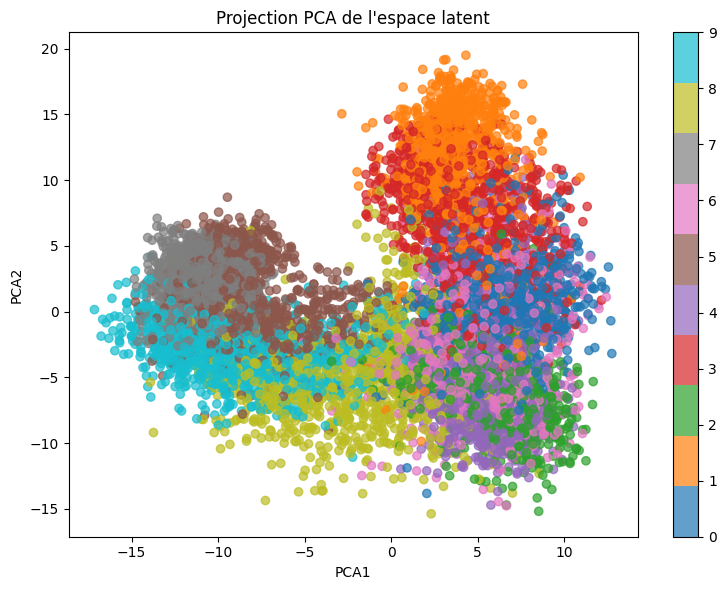

In [64]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))  # 1 seul graphique

cvae_beta_petit.eval() #mode eval

# Représentation latente avec PCA
with torch.no_grad():
    test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
    data, labels = next(iter(test_loader))
    data = data.to(device)
    labels = labels.to(device)
    one_hot_labels = one_hot(labels, class_size=10).to(device)

    # Encodage des données dans l'espace latent
    mu, logvar = cvae_beta_petit.encode(data, one_hot_labels)
    z = mu.cpu().numpy()  
    labels = labels.cpu().numpy()  

    # Application de PCA pour réduire à 2 dimensions
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z)  # Réduction de dimension

    # Scatter plot de la projection PCA
    scatter = axs.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs.set_title('Projection PCA de l\'espace latent')
    axs.set_xlabel('PCA1')
    axs.set_ylabel('PCA2')
    fig.colorbar(scatter, ax=axs, ticks=range(10))

plt.tight_layout()
plt.show()

Comme vu précédemment, les données sont bien séparées dans l'espace latent.

#### 3.3 Modèle avec un β important

Afin de vérifier les propos précédents, nous allons maintenant montrer les résultats avec un modèle dont l'hyper-paramètre beta est grand, égal à 10.

In [52]:
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
epochs = 20
beta = 10

# Modèle et optimizer
cvae_beta_grand = ConvCVAE(latent_dim=latent_dim, num_classes=10) 
cvae_beta_grand.to(device)
optimizer = optim.Adam(cvae_beta_grand.parameters(), lr=learning_rate)

# Listes pour stocker la loss et la MSE par epoch
loss_history_grand = []
mse_history_grand = []

for epoch in range(1, epochs + 1):
    cvae_beta_grand.train()  # Entraînement du modèle
    
    running_loss = 0.0  
    running_mse = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # Conversion des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae_beta_grand(data, one_hot_labels)

        # Calcul des métriques
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
        mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse += mse

    # Calcul de la loss et de la MSE par epoch
    epoch_loss_grand = running_loss / len(train_loader.dataset)
    epoch_mse_grand = running_mse / len(train_loader.dataset)
    loss_history_grand.append(epoch_loss_grand)
    mse_history_grand.append(epoch_mse_grand)
    
    print(f'Epoch {epoch}, Training loss: {epoch_loss_grand:.4f},  Training mse: {epoch_mse_grand:.4f}')

Epoch 1, Training loss: 307.9483,  Training mse: 0.0003
Epoch 2, Training loss: 286.0516,  Training mse: 0.0003
Epoch 3, Training loss: 283.0404,  Training mse: 0.0003
Epoch 4, Training loss: 281.6085,  Training mse: 0.0002
Epoch 5, Training loss: 280.6391,  Training mse: 0.0002
Epoch 6, Training loss: 279.8212,  Training mse: 0.0002
Epoch 7, Training loss: 279.4632,  Training mse: 0.0002
Epoch 8, Training loss: 279.0398,  Training mse: 0.0002
Epoch 9, Training loss: 278.7286,  Training mse: 0.0002
Epoch 10, Training loss: 278.3040,  Training mse: 0.0002
Epoch 11, Training loss: 278.1544,  Training mse: 0.0002
Epoch 12, Training loss: 277.9303,  Training mse: 0.0002
Epoch 13, Training loss: 277.8323,  Training mse: 0.0002
Epoch 14, Training loss: 277.6061,  Training mse: 0.0002
Epoch 15, Training loss: 277.4319,  Training mse: 0.0002
Epoch 16, Training loss: 277.3694,  Training mse: 0.0002
Epoch 17, Training loss: 277.1152,  Training mse: 0.0002
Epoch 18, Training loss: 277.0260,  Trai

Evaluation du modèle

In [53]:
cvae_beta_grand.eval()

ConvCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=2058, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=2058, out_features=20, bias=True)
  (fc_decode): Linear(in_features=30, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (

Reconstruction d'images

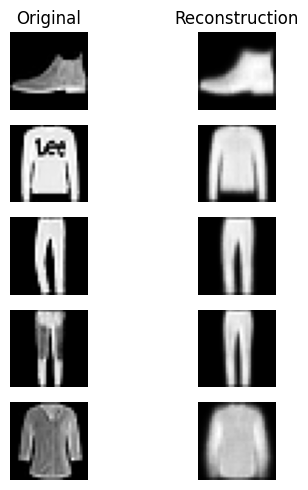

In [54]:
# Récupération d'images et de leur label dans le dataset
random_images, labels = next(iter(test_loader))  

#Conversion des labels
one_hot_labels = one_hot(labels, class_size=10).to(device) 

# Récupération des images reconstruites correspondantes
recons, _, _ = cvae_beta_grand(random_images.to(device), one_hot_labels)  

random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

image_comparison(random_images, recons)

Génération d'échantillons aléatoires

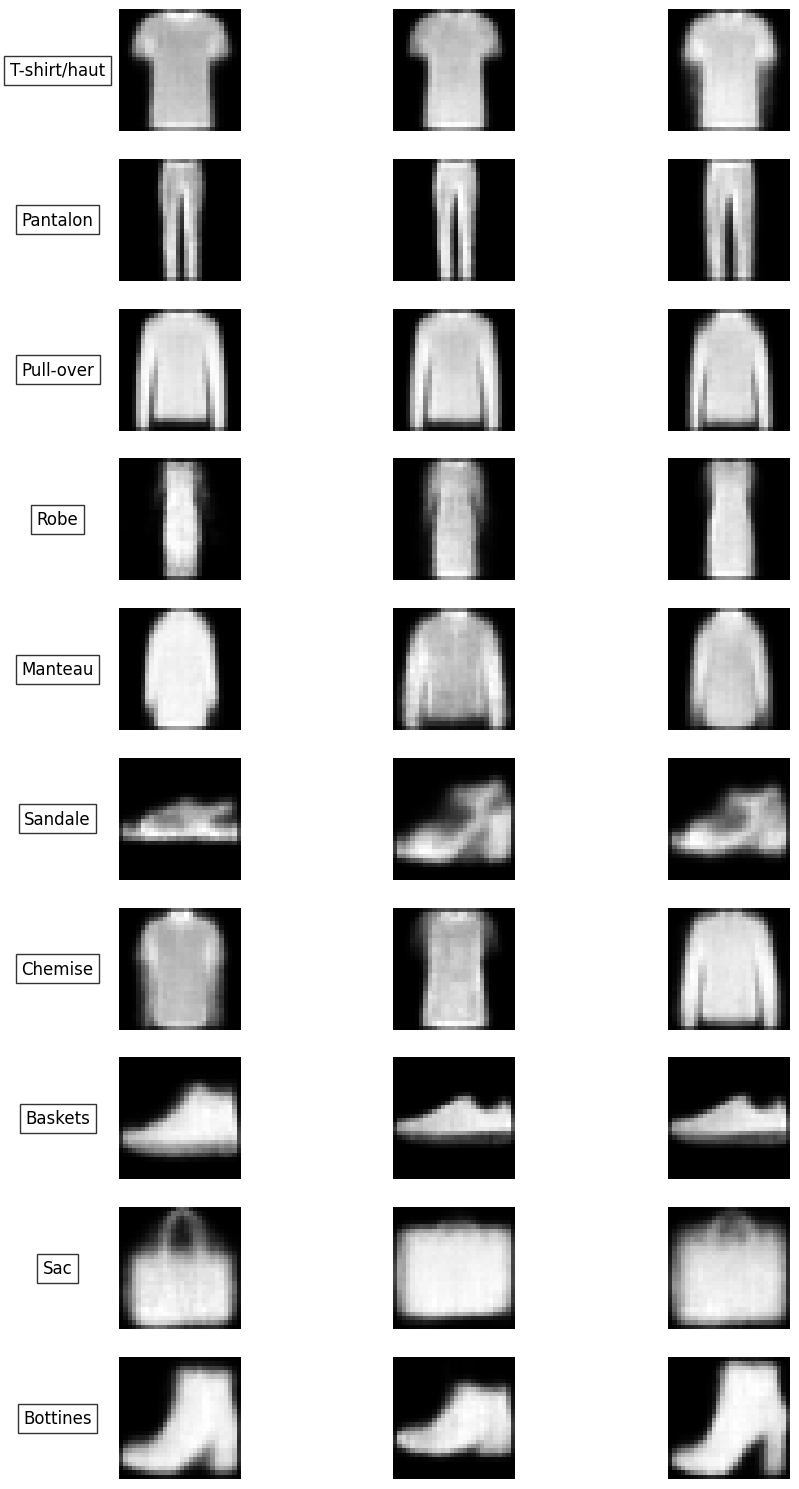

In [55]:
num_samples_per_class = 3
num_classes = 10

samples = generate_samples_per_class(cvae_beta_grand, num_classes, num_samples_per_class)


fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, noms_classes[class_label], 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

Pour un beta grand, la reconstruction des données est moins bonne que dans le cas où le beta est petit, les images sont plus floues. Concernant la génération de données, elle est bien meilleure dans le cas du beta grand, les vêtements sont reconnaissables.

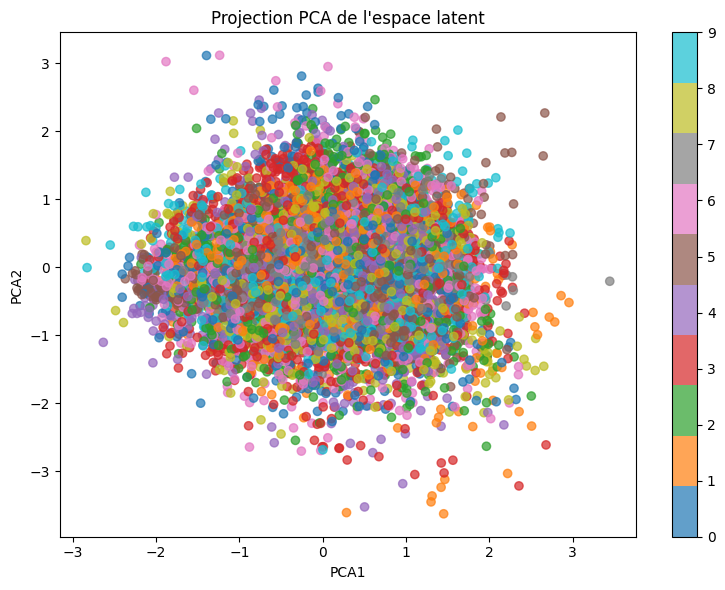

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))  # 1 seul graphique

cvae_beta_grand.eval()

# Représentation latente avec PCA
with torch.no_grad():
    test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
    data, labels = next(iter(test_loader))
    data = data.to(device)
    labels = labels.to(device)
    one_hot_labels = one_hot(labels, class_size=10).to(device)

    # Encodage des données dans l'espace latent
    mu, logvar = cvae_beta_grand.encode(data, one_hot_labels)
    z = mu.cpu().numpy()  
    labels = labels.cpu().numpy()  

    # Application de PCA pour réduire à 2 dimensions
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z)  # Réduction de dimension

    # Scatter plot de la projection PCA
    scatter = axs.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs.set_title('Projection PCA de l\'espace latent')
    axs.set_xlabel('PCA1')
    axs.set_ylabel('PCA2')
    fig.colorbar(scatter, ax=axs, ticks=range(10))

plt.tight_layout()
plt.show()

La représentation des données dans l'espace latent montre des points mélangés et une représentation non structurée telle une représentation gaussienne.

## **4. Conclusion**

L'optimisation des hyperparamètres d'un modèle Convolutionnel Variationel Auto-Encodeur dépend de l'objectif final de l'utilisateur. 

En effet, pour optimiser un CVAE il faut trouver un bon compromis entre :
- La qualité de reconstruction des données, qui reflète la capacité du modèle à reproduire fidèlement les données originales.
- La qualité de représentation dans l'espace latent, qui influence directement la capacité de génération de nouvelles données.

Nous avons observé que : 
- Pour assurer une bonne **représentation des données dans l'espace latent** et une bonne qualité de génération de données, il fallait que le facteur beta soit important pour que le terme de régularisation de KL ait un impact. Cependant avec un beta élevé, la reconstruction des données n'est pas bonne puisque l'information des données originales est compromise lors de sa représentation dans l'espace latent. 
- Pour assurer une **reconstruction fidèle des données**, il ne faut pas donner trop de poids au facteur de régularisation. Cela permettrait ainsi de conserver les données initiales et de les reproduire correctement, au détriment de sa généralisabilité dans l'espace latent.

En conclusion, le CVAE permet de capturer des représentations latentes structurées et générer de nouvelles données, mais son efficacité repose sur un équilibre entre reconstruction fidèle des données originales et structuration cohérente de l'espace latent, adapté à l'objectif fixé.

## **5. Références**

- Définition de VAE et CVAE : https://ijdykeman.github.io/ml/2016/12/21/cvae.html
ou https://deepgram.com/ai-glossary/conditional-variational-autoencoders
- Choix des couches du modèle :  https://inside-machinelearning.com/cnn-couche-de-convolution/
- Explication sur les termes de la fonction de perte : https://medium.com/@mrthinger/kl-divergence-vs-cross-entropy-exploring-the-differences-and-use-cases-3f3dee58c452